# Feature Tracking
Various feature tracking algorithms

In [909]:
import numpy as np
from scipy import ndimage as nd
import math
from PIL import Image
import matplotlib.pyplot as plt

In [910]:
# Gradient in x-direction
def Sobelx(image):
    sobelx = np.array([[1,0,-1],
                    [2,0,-2],
                    [1,0,-1]])
    Ix = nd.convolve(image,sobelx)           
    return Ix


# Gradient in y-direction
def Sobely(image):
    sobely = np.array([[ 1, 2, 1],
                    [ 0, 0, 0],
                    [-1,-2,-1]])

    Iy = nd.convolve(image,sobely)
    return Iy


# Convert RGB to grayscale
def rgb2gray(image):
    image = np.array(image)
    r, c, ch = image.shape
    gray = np.zeros([r,c])

    gray = np.mean(image, axis=2)
    return gray


# Reduce image size
def reduceRes(image,factor):
    r,c = image.size
    r = np.int(np.floor(r/factor))
    c = np.int(np.floor(c/factor))
    new = image.resize((r,c))
    return new


# Box filter for smoothing
def boxFilter(image,rc):
    box = np.ones([rc,rc])/rc**2
    image = nd.convolve(gray,box)
    return image


# Pad image with zeros
def pad(image,factor):
    r_img, c_img = image.shape
    pad = np.zeros([r_img,factor])
    image = np.hstack([pad,image,pad])

    r_img, c_img = image.shape
    pad = np.zeros([factor,c_img])
    image = np.vstack([pad,image,pad])

    return image


# Peak finding for nonmax supression
def peaks(image,window):
    factor = int(np.floor(window/2))
    image = pad(image,factor)
    peaks = np.zeros([image.shape[0],image.shape[1]])

    for i in range(1,image.shape[0]-1):
        for j in range(1,image.shape[1]-1):
            window = image[i-1:i+2,j-1:j+2]
            if image[i,j]==np.amax(window):
                peaks[i,j] = image[i,j]


    # remove padding
    peaks = peaks[factor:-factor,factor:-factor]

    return peaks


# Norm CC feature matching
def norm_cross_corr(image,filter):
    r,c = image.shape
    ncc = np.zeros([r,c])
    
    add = np.int((filter.shape[0]-1)/2)
    padded = pad(image,add)

    for i in range(r):
        for j in range(c):
            f = padded[i:i+filter.shape[0],j:j+filter.shape[1]]
            if np.sum(np.sqrt(f**2))==0:
                norm_f = np.zeros([f.shape[0],f.shape[1]])
            else:
                norm_f = f/np.sqrt(np.sum(f**2))
            norm_g = filter/np.sqrt(np.sum(filter**2))

            norm_f = np.reshape(norm_f,[1,filter.size])
            norm_g = np.reshape(norm_g,[filter.size,1])

            ncc[i,j] = np.dot(norm_f,norm_g)
            
    return ncc

# Harris Corner Detector
The Harris corner detector is a corner detection operator that is commonly used in computer vision algorithms to extract corners and infer features of an image. It was first introduced by Chris Harris and Mike Stephens in 1988 upon the improvement of Moravec's corner detector.[1] Compared to the previous one, Harris' corner detector takes the differential of the corner score into account with reference to direction directly, instead of using shifting patches for every 45 degree angles, and has been proved to be more accurate in distinguishing between edges and corners.[2] Since then, it has been improved and adopted in many algorithms to preprocess images for subsequent applications.

135000


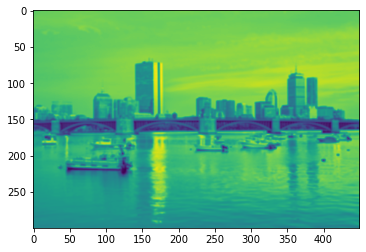

In [911]:
# Load image
file = 'boston_skyline.jpg'
image = Image.open(file)

# Reduce resolution
image = reduceRes(image,2)

# Convert to grayscale
gray = rgb2gray(image)

# Smooth image
gray = boxFilter(gray,3)

print(gray.size)
plt.imshow(gray)

In [912]:
def HarrisCorner(image,threshold):

    # Find gradients
    Ix = Sobelx(image)
    Iy = Sobely(image)
    Ixx = Ix**2
    Iyy = Iy**2

    # Compute R values
    detM = Ixx*Iyy
    traceM = Ixx+Iyy
    k = 0.05
    R = detM - k*traceM**2

    # Threshold values
    R[R <= threshold*np.amax(R)] = 0
    
    # Nonmax Supression
    R = peaks(R,3)

    return R

Number of features: 151
147 264
[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 4.81893196e+08
  0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00]]


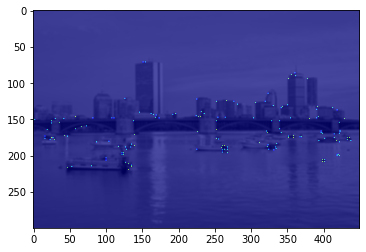

In [913]:
threshold = 0.05
corners = HarrisCorner(gray,threshold)
plt.imshow(gray, cmap = "gray")
plt.imshow(corners>0, cmap = "jet", alpha = 0.7)

idx = np.where(corners>0)
idx = np.array(idx).T
print('Number of features:',idx.shape[0])

# Choose random corner
rand_corner = np.random.randint(idx.shape[0],size=1)
loc = idx[rand_corner,:]
loc = np.concatenate(loc)
r = loc[0]
c = loc[1]
print(r,c)
patch = np.around(corners[r-3:r+4,c-3:c+4])
print(patch)

(array([ 26,  28,  30,  34,  34,  54,  61,  62,  64,  65,  65,  65,  67,
        69,  70,  71,  72,  74,  76,  77,  79,  80,  82,  82,  83,  87,
        87,  88,  88,  88,  89,  89,  92,  92,  92,  92,  94, 103, 104,
       107, 108, 110, 111, 115, 116, 119, 119, 119, 120, 121, 122, 123,
       124, 126, 127, 128, 131, 131, 136, 149, 151, 159]), array([270, 265, 271, 261, 287, 233,  36, 135, 176, 162, 186, 229, 216,
       191, 260, 240, 301, 322, 300, 328, 141,  56, 106, 145, 102, 164,
       174,  83, 213, 264, 290, 338,  48, 162, 238, 249, 331, 249, 162,
       136, 251, 324,  49, 324, 311, 303, 327, 347,  14, 331, 221, 245,
        45,  49,  27,  44, 135, 234, 177,  37,  41,  41]))
Matches: 62


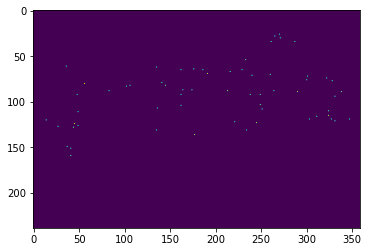

In [921]:
fit = norm_cross_corr(corners,patch)
fit[fit<1] = 0
plt.imshow(fit)

best = np.where(fit==np.amax(fit))
print(best)
best = np.array(best).T
print('Matches:',best.shape[0])

Split images for testing

In [915]:
# Split image into top left and bottom right with overlap
r,c = gray.shape
split = 5
topleft = gray[0:np.int(np.floor(r-r/split)), 0:np.int(np.floor(c-c/split))]
botright = gray[np.int(np.floor(r-(split-1)*r/split)):-1, np.int(np.floor(c-(split-1)*c/split)):-1]

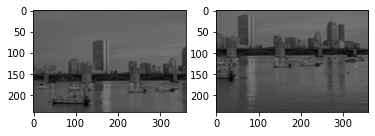

In [916]:
threshold = 0.05

plt.subplot(1,2,1)
corners = HarrisCorner(topleft,threshold)
plt.imshow(topleft, cmap = "gray")
plt.imshow(corners, cmap = "gray", alpha=0.5)


plt.subplot(1,2,2)
corners = HarrisCorner(botright,threshold)
plt.imshow(botright, cmap = "gray")
plt.imshow(corners, cmap = "gray", alpha=0.5)

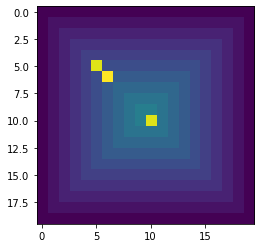

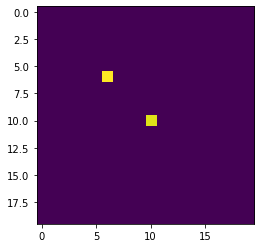

In [917]:
dim = 20
test = np.zeros([dim,dim])

for i in range(int(dim/2)):
    test[i:-i,i:-i] = i
test[5,5] = 20
test[6,6] = 21
test[10,10] = 20

plt.imshow(test)
plt.show()

test = peaks(test,3)
plt.imshow(test)